## AL dataset que nos dieron ya se le aplicaron todos los cambios, son imagenes del dominio de la frecuencia del audio usando coeficientes cepstrales en frecuencia mel
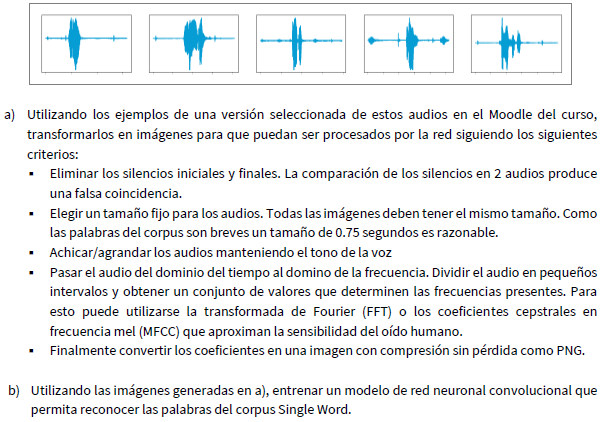

In [3]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR  = '../../Datos-Fuentes/Fuentes/'     # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR    = '../../Datos-Fuentes/Datos/'      # carpeta donde se encuentran los datasets
MODELOS_DIR  = '../Modelos/'    # carpeta donde se encuentran los modelos
ARCHIVOs_DIR = '../Archivos/'   # carpeta recuperar o copiar archivos

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

## Importo librerias

In [4]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Flatten,Dropout,Dense, Input, InputLayer, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import skimage.io as io
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob


## Preparo datos

In [3]:

def import_data(img_list):
    img_data = []
    label_data = []
    
    img_count = len(img_list)
    for i in range(0,img_count):
        img = img_list[i]
        img_read = io.imread(img)

        img_read = img_read/img_read.max() # normaliza pixeles entre 0 y 1
        img_read = img_read.reshape((*img_read.shape,1))

        #img_read = img_read[:,:,0]         # extrae 1er canal porque estan en escala de grises
        #img_read = img_read.flatten()      # redefine como arreglo de 1 dimension
        img_data.append(img_read)          # agrega a lista de imágenes a procesar
        label_data.append(img[img.rindex('_')+1:-4])         # extrae texto de la palabra desde el nombre del archivo
        # muestra progreso en la carga
        if i % 100 == 0:
            print("\rCargando imágenes (%d): %6.2f%%" % (i,100*i/img_count), end="")
    print("\rCargando imágenes (%d): 100.00%%\n" % i)
        
    return np.array(img_data), np.array(label_data)


IMG_ERROR = 'No hay imágenes para cargar. Verificar que la ruta sea correcta y que la carpeta tenga imagenes con la extensión usada'

# %% Carga imágenes de entrenamiento y testeo desde las carpetas

# lista de archivos para entrenamiento

train_img_list = glob.glob(DATOS_DIR + 'Voz-Espectros/Espectros/Train/*.png')
assert len(train_img_list) > 0, IMG_ERROR 

     
# carga las imagenes a partir de los nombres de archivos
xtrain, yraw = import_data(train_img_list)


# %% Establece parámetros de entrenamiento

# tamano de imagen extraido de los datos
IMG_SIZE = (xtrain.shape[1], xtrain.shape[2],1)


# cantidad de pasadas de los datos
EPOCAS = 200
# cantidad de datos a procesar para actualizar pesos
LOTES  = 300

# %% binariza valores del target

# conviertes el id de la clase en "one hot encoding": clase 3 => [0,0,0,1,0,0]
# Binarizador para convertir el nombre de la clase en one hot encoding 
binarizador = preprocessing.LabelBinarizer()
ytrain= binarizador.fit_transform(yraw)

# cantidad de clases
# N_CLASSES = len(np.unique(yraw))
CLASES  = binarizador.classes_

# %% Separa los datos y clase en grupo de entrenamiento y validacion
x_train, x_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size = 0.10, shuffle=True)

Cargando imágenes (10281): 100.00%



## Construyo modelo

In [5]:
def build_model(img_size, classes):
    ACTIVATION = LeakyReLU()
    model = Sequential()
 
    model.add(InputLayer(input_shape=img_size))

    # CONV => RELU => BN => POOL
    model.add(Conv2D(16, (3, 3), strides=(1,1), padding="same", activation=ACTIVATION))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), strides=(1,1), padding="same", activation=ACTIVATION))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), strides=(1,1), padding="same", activation=ACTIVATION))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding="same", activation=ACTIVATION))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding="same", activation=ACTIVATION))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

        
    model.add(Flatten())
    
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation='softmax'))

    return model    

# obtiene la arquitectura para el modelo y lo compila
model = build_model(IMG_SIZE, len(CLASES))
model.summary()
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


c:\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 65, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,990 (308.55 KB)

 Trainable params: 78,574 (306.93 KB)

 Non-trainable params: 416 (1.62 KB)

## Entreno modelo

In [6]:
es = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True) 

# entrena el modelo y guarda la historira del progreso    
H=model.fit(x = x_train, y = y_train, batch_size = LOTES, epochs = EPOCAS, 
          validation_data = (x_val, y_val), callbacks=[es])

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.2920 - loss: 2.2472 - val_accuracy: 0.0603 - val_loss: 2.6347
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.6963 - loss: 1.1002 - val_accuracy: 0.0603 - val_loss: 2.6779
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.7879 - loss: 0.8105 - val_accuracy: 0.0680 - val_loss: 2.7283
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.8460 - loss: 0.6250 - val_accuracy: 0.0632 - val_loss: 2.8403
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.8714 - loss: 0.5147 - val_accuracy: 0.0661 - val_loss: 2.8764
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.9003 - loss: 0.4189 - val_accuracy: 0.0661 - val_loss: 2.9459
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9087 - loss: 0.3763 - val_accuracy: 0.0632 - val_loss: 3.0150
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9257 - loss: 0.3172 - val_accu

## Evaluo modelo y veo rendimiento


Porcentaje de acierto del modelo con datos de entrenamiento...:  99.97%
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Porcentaje de acierto del modelo con datos de validación......:  96.11%


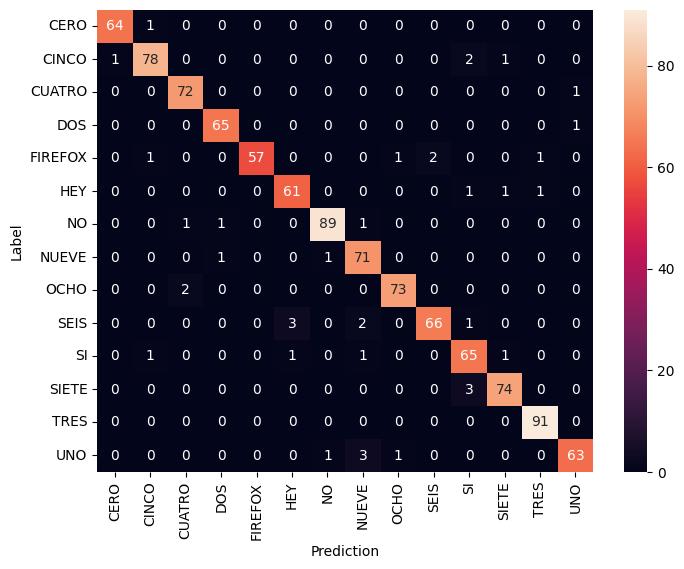

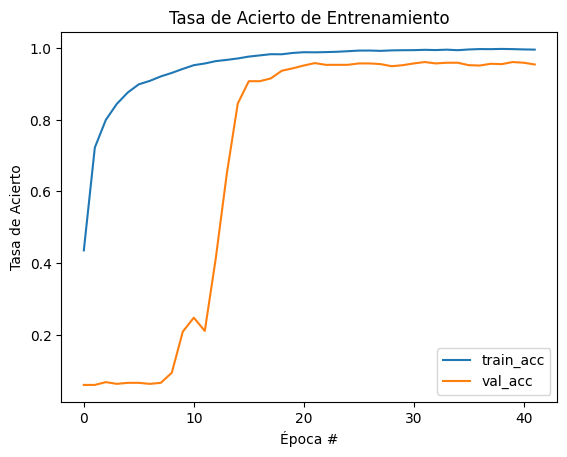

Cargando imágenes (6348): 100.00%

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Porcentaje de acierto del modelo con datos de testeo..........:  75.79%


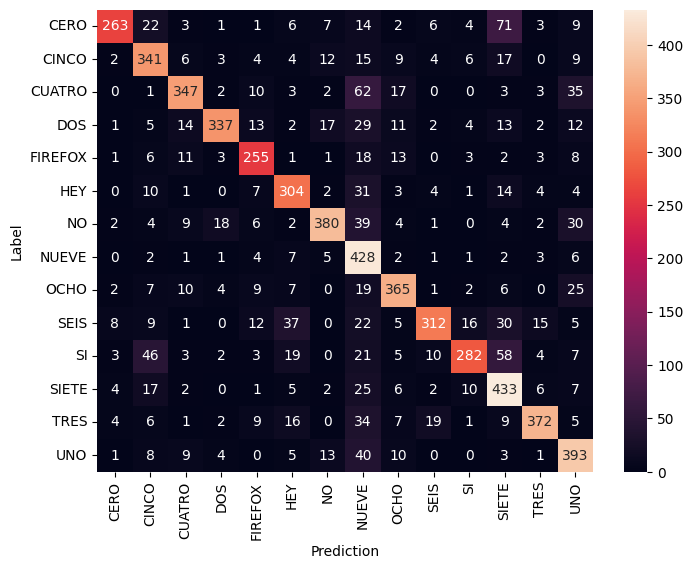

In [8]:
# %% Evalua e informa resultado de entrenamiento, validación y testeo
# evalua el modelo con los datos de entreanmiento
pred = model.evaluate(x_train, y_train, verbose=0)
tasa_ent = pred[1]*100
print("\nPorcentaje de acierto del modelo con datos de entrenamiento...: %6.2f%%" % tasa_ent)

# evalua el modelo con los datos de validacion
y_pred = model.predict(x_val)
y_pred_tx = binarizador.inverse_transform(y_pred)
y_val_tx = binarizador.inverse_transform(y_val)
tasa_val = 100*np.sum(y_pred_tx==y_val_tx)/len(y_val)

print("Porcentaje de acierto del modelo con datos de validación......: %6.2f%%" % tasa_val)

confusion_mtx = confusion_matrix(y_val_tx, y_pred_tx)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=CLASES,
            yticklabels=CLASES,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')



# plot the training loss and accuracy
plt.figure()
#plt.plot(N, H.history["loss"], label="train_loss")
#plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Tasa de Acierto de Entrenamiento")
plt.xlabel("Época #")
plt.ylabel("Tasa de Acierto")
plt.legend(loc="lower right")

plt.show()

y_val#%% Verificación con datos de testeo
img_list = glob.glob(DATOS_DIR + 'Voz-Espectros/Espectros/Test/*.png')
assert len(img_list) > 0, IMG_ERROR 

     
# carga las imagenes a partir de los nombres de archivos
x_test, yraw = import_data(img_list)
#y_test = binarizador.transform(yraw)
y_test_tx = yraw

# evalua el modelo con los datos de validacion
y_pred = model.predict(x_test)
y_pred_tx = binarizador.inverse_transform(y_pred)

tasa_test = 100*np.sum(y_pred_tx==y_test_tx)/len(y_test_tx)

print("Porcentaje de acierto del modelo con datos de testeo..........: %6.2f%%" % tasa_test)

confusion_mtx = confusion_matrix(y_test_tx, y_pred_tx)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=CLASES,
            yticklabels=CLASES,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label');
